In [ ]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

In [1]:
! pip install git+https://github.com/nicola-decao/power_spherical.git

  Cloning https://github.com/nicola-decao/power_spherical.git to /tmp/pip-req-build-yqze983w
  Running command git clone --filter=blob:none --quiet https://github.com/nicola-decao/power_spherical.git /tmp/pip-req-build-yqze983w
  Resolved https://github.com/nicola-decao/power_spherical.git to commit 3d4619a9d6c01bc9b427533d386271a233e304cd
  Preparing metadata (setup.py) ... done
  Created wheel for power_spherical: filename=power_spherical-0.1.0-py3-none-any.whl size=5154 sha256=b7b2626d8b40a15aed7dc7afe8add4d6f83ee4d1270bd0996f92433e58fd53c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-79qa1kwe/wheels/21/0e/c8/730ab253327805c08a91a91622554429592e1888a7fa7e69ca
Successfully built power_spherical


In [2]:
! pip install -U lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 104.6 MB/s eta 0:00:00


In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using {device} device")

Using cuda device


In [4]:
# ! tensorboard --logdir . --bind_all

# Loading datasets

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import requests
import os
import random
import torch

In [6]:
def download_file(url, filename, force_download=False, stream=True):
    """
    Downloads a file from a specified URL.

    :param url: URL of the file to download.
    :param filename: Local filename to save the downloaded file.
    :param force_download: If True, forces the download even if the file already exists.
    :param stream: If True, downloads the file in chunks to save memory.
    """
    
    # Check if the file already exists
    if os.path.exists(filename) and not force_download:
        print(f"File '{filename}' already exists.")
        return
    
    # Send a GET request to the specified URL
    response = requests.get(url, stream=stream)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in write-binary mode
        with open(filename, 'wb') as file:
            if stream:
                # Write the content of the response to the file in chunks
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        file.write(chunk)
            else:
                # Write the full content at once
                file.write(response.content)
                
        print(f"File '{filename}' downloaded successfully.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

In [ ]:
# plot some images

def plot_images(images, n_images, randomize):
    if randomize:
        selected_images = random.sample(range(len(images)), n_images)
    else:
        selected_images = range(n_images)
    
    fig, axes = plt.subplots(1, n_images, figsize=(n_images, 1))
    for i, image_idx in enumerate(selected_images):
        axes[i].imshow(images[image_idx])
        axes[i].axis('off')
    plt.show()

## 3dshapes dataset

In [ ]:
# https://github.com/google-deepmind/3d-shapes

dataset_url = 'https://storage.googleapis.com/3d-shapes/3dshapes.h5'
dataset_filename = 'Datasets/3dshapes.h5'

download_file(dataset_url, dataset_filename)

File 'Datasets/3dshapes.h5' already exists.


In [9]:

# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']

_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

print(f"image shape: {image_shape}, label shape: {label_shape}, n_samples: {n_samples}")

<KeysViewHDF5 ['images', 'labels']>
image shape: (64, 64, 3), label shape: (6,), n_samples: 480000


In [10]:
labels = np.array(labels)

In [11]:
images[0], labels[100]

(array([[[153, 226, 249],
         [153, 226, 249],
         [153, 226, 249],
         ...,
         [153, 226, 249],
         [153, 226, 249],
         [153, 226, 249]],
 
        [[153, 226, 249],
         [153, 226, 249],
         [153, 226, 249],
         ...,
         [153, 226, 249],
         [153, 226, 249],
         [153, 226, 249]],
 
        [[153, 226, 249],
         [153, 226, 249],
         [153, 226, 249],
         ...,
         [153, 226, 249],
         [153, 226, 249],
         [153, 226, 249]],
 
        ...,
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [235,   0,   0],
         [237,   0,   0],
         [236,   0,   0]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [230,   0,   0],
         [225,   0,   0],
         [231,   0,   0]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [230,   0,   0],
  

In [12]:
# print each factor and crossponding values

for i, factor_name in enumerate(_FACTORS_IN_ORDER):
    num_values = _NUM_VALUES_PER_FACTOR[factor_name]
    factor_values = labels[:, i]
    unique_values = np.unique(factor_values)
    print(f'{i}: {factor_name} (num_values={num_values}) \n values={unique_values}')

0: floor_hue (num_values=10) 
 values=[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
1: wall_hue (num_values=10) 
 values=[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
2: object_hue (num_values=10) 
 values=[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
3: scale (num_values=8) 
 values=[0.75       0.82142857 0.89285714 0.96428571 1.03571429 1.10714286
 1.17857143 1.25      ]
4: shape (num_values=4) 
 values=[0. 1. 2. 3.]
5: orientation (num_values=15) 
 values=[-30.         -25.71428571 -21.42857143 -17.14285714 -12.85714286
  -8.57142857  -4.28571429   0.           4.28571429   8.57142857
  12.85714286  17.14285714  21.42857143  25.71428571  30.        ]


In [13]:
labels[:,3] = labels[:,3] - 0.75
np.unique(labels[:,3])

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       ])

In [14]:
print(f"image shape: {images[0].shape}, label shape: {labels[0].shape}, n_samples: {n_samples}")

image shape: (64, 64, 3), label shape: (6,), n_samples: 480000


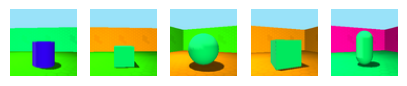

In [15]:
plot_images(images, n_images=5, randomize=True)

In [ ]:
def get_image_indices(selected_factors):
    not_selected_factors = [key for key in _FACTORS_IN_ORDER if key not in selected_factors]

    print(f"not selected factors: {not_selected_factors}")
    
    selected_sample_indices = np.ones(n_samples, dtype=bool)

    for not_selected_factor in not_selected_factors:
        selected_sample_indices &= labels[:, _FACTORS_IN_ORDER.index(not_selected_factor)] == 0
    
    selected_sample_indices = np.where(selected_sample_indices)[0] # get indices of True values
    
    return selected_sample_indices

In [ ]:
# select a subset of images based the chosen ground truth factors (based on the names of the factors)
selected_factors = ["floor_hue", "wall_hue", "shape", "object_hue"]
selected_factor_indices = [i for i, factor in enumerate(_FACTORS_IN_ORDER) if factor in selected_factors]

In [18]:
selected_images_3dsShapes_indices = get_image_indices(selected_factors)
# print(f"Number of images selected: {selected_images_3dsShapes_indices.sum()}")
print(f"Number of images selected: {len(selected_images_3dsShapes_indices)}")

selected_images_3dsShapes = images[selected_images_3dsShapes_indices]

not selected factors: ['scale', 'orientation']
Number of images selected: 4000


In [19]:
# convert it to tensor make it first channel
# selected_images_3dsShapes_tensor = torch.tensor(selected_images_3dsShapes).permute(0, 3, 1, 2).float()
selected_images_3dsShapes_tensor = torch.tensor(selected_images_3dsShapes).permute(0, 3, 1, 2).float() / 255.0

print(f"Shape of the selected images tensor: {selected_images_3dsShapes_tensor.shape}")

Shape of the selected images tensor: torch.Size([4000, 3, 64, 64])


In [20]:
selected_images_3dsShapes_labels_tensor = torch.tensor(labels[selected_images_3dsShapes_indices])
selected_images_3dsShapes_labels_tensor = selected_images_3dsShapes_labels_tensor[:, selected_factor_indices]

print(f"Shape of the selected labels tensor: {selected_images_3dsShapes_labels_tensor.shape}")

Shape of the selected labels tensor: torch.Size([4000, 4])


In [ ]:
import torch

# Assuming selected_images_3dsShapes_tensor is your tensor
tensor = selected_images_3dsShapes_tensor

# Calculate the range
tensor_min = tensor.min()
tensor_max = tensor.max()
tensor_range = tensor_max - tensor_min

print(f"Min value: {tensor_min}")
print(f"Max value: {tensor_max}")
print(f"Range: {tensor_range}")

Min value: 0.0
Max value: 1.0
Range: 1.0


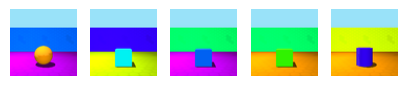

In [22]:
plot_images(selected_images_3dsShapes, n_images=5, randomize=True)

# dsprites-dataset

In [23]:
dataset_filename = 'Datasets/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
dSprites_dataset = np.load(dataset_filename, encoding='bytes', allow_pickle=True)
dSprites_dataset

NpzFile 'Datasets/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz' with keys: metadata, imgs, latents_classes, latents_values

In [ ]:
dSprites_factors = ["color", "shape", "scale", "orientation", "posX", "posY"]

In [25]:
# dsprites metadata
print(dSprites_dataset['metadata'])

{b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.1887902 , 4.34989

In [26]:
dSprites_images = dSprites_dataset['imgs']
dSprites_latents_classes = dSprites_dataset['latents_classes']
dSprites_latents_values = dSprites_dataset['latents_values']

In [ ]:
print(dSprites_images.shape, dSprites_latents_classes.shape, dSprites_latents_values.shape)
print(dSprites_latents_classes)

(737280, 64, 64) (737280, 6) (737280, 6)
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]
 [ 0  0  0  0  0  2]
 ...
 [ 0  2  5 39 31 29]
 [ 0  2  5 39 31 30]
 [ 0  2  5 39 31 31]]


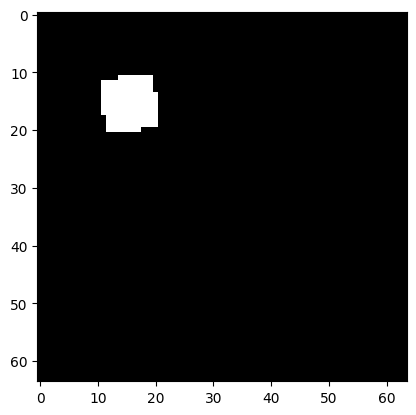

In [28]:
plt.imshow(dSprites_images[1024], cmap='gray')

In [ ]:
dSprites_selected_factors = ["color", 'posX', 'posY', 'shape', 'scale']

In [30]:
def get_dSprites_image_indices(selected_factors):
    not_selected_factors = [factor for factor in dSprites_factors if factor not in selected_factors]

    print(f"not selected factors: {not_selected_factors}")
    
    selected_sample_indices = np.ones(dSprites_images.shape[0], dtype=bool)

    for not_selected_factor in not_selected_factors:
        selected_sample_indices &= dSprites_latents_classes[:, dSprites_factors.index(not_selected_factor)] == 0
    
    selected_sample_indices = np.where(selected_sample_indices)[0] # get indices of True values
    
    return selected_sample_indices

In [31]:
sampled_dSprites_indices = get_dSprites_image_indices(dSprites_selected_factors)

not selected factors: ['orientation']


In [32]:
sampled_dSprites_indices.shape

(18432,)

In [33]:
selected_dSprites_images = dSprites_images[sampled_dSprites_indices]
selected_dSprites_latents_values = dSprites_latents_values[sampled_dSprites_indices]

print(f"Shape of the selected dSprites images: {selected_dSprites_images.shape}, shape of the selected dSprites latents values: {selected_dSprites_latents_values.shape}")

Shape of the selected dSprites images: (18432, 64, 64), shape of the selected dSprites latents values: (18432, 6)


In [34]:
selected_dSprites_images = torch.tensor(selected_dSprites_images).unsqueeze(1).float()
selected_dSprites_latents_values = torch.tensor(selected_dSprites_latents_values)

print(f"Shape of the selected dSprites images: {selected_dSprites_images.shape}, shape of the selected dSprites latents values: {selected_dSprites_latents_values.shape}")

Shape of the selected dSprites images: torch.Size([18432, 1, 64, 64]), shape of the selected dSprites latents values: torch.Size([18432, 6])


# Dataset utils

In [ ]:
class DatasetTensor(torch.utils.data.Dataset):
    def __init__(self, images_tensor, labels_tensor):
        self.images = images_tensor
        self.labels = labels_tensor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [36]:
def random_sample_data(data, n_samples):
    n_data = len(data)
    indices = random.sample(range(n_data), n_samples)
    sampled =  [data[i] for i in indices]
    # make it tensor
    sampled = torch.stack(sampled)
    return sampled

# Plot functions

In [37]:
import torch
import torchvision
import matplotlib.pyplot as plt

def plot_tensor_grid(title, tensor, n_cols=5, figsize=(10, 10), normalize=False, show_axis=False):
    """
    Plots a tensor of images in a grid.

    Parameters:
    - tensor (torch.Tensor): The input tensor of size [N, C, H, W], where
                             N is the number of images,
                             C is the number of channels,
                             H is the height, and
                             W is the width.
    - nrow (int): Number of images per row in the grid.
    - figsize (tuple): Size of the figure for plotting.
    - show_axis (bool): Whether to show axes in the plot.
    """
    # Normalize each image in the tensor individually
    tensor = tensor.clone().cpu()  # Clone to avoid modifying the original tensor

    if normalize:
        for i in range(tensor.size(0)):
            img = tensor[i]
            img_min = img.min()
            img_max = img.max()
            tensor[i] = (img - img_min) / (img_max - img_min)  # Normalize to [0, 1]
        
    # Use torchvision's make_grid to create a grid of images
    # nrows specify the number of images per row
    grid_img = torchvision.utils.make_grid(tensor, nrow=n_cols)

    # Convert the grid to a numpy array
    np_grid = grid_img.permute(1, 2, 0).numpy()

    # Plot the grid
    plt.figure(figsize=figsize)
    plt.imshow(np_grid)
    if not show_axis:
        plt.axis('off')  # Remove axes for better visualization
    
    plt.title(title)
    plt.show()

# S-VAE

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

from power_spherical import HypersphericalUniform, PowerSpherical

## Encoder & Decoder

In [67]:
# Encoder network
class Encoder(nn.Module):
    def __init__(self, input_channels_num, output_dim):
        super(Encoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Conv2d(input_channels_num, 32, 4, stride=2, padding=1),  # 64x64xinput_channels -> 32x32x32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 4, stride=2, padding=1),  # 32x32x32 -> 16x16x32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 16x16x64 -> 8x8x64
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),  # 8x8x64 -> 4x4x64
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(4 * 4 * 64, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim)  # mu and logvar output
        )
    
    def forward(self, x):
        return self.encode(x)

In [68]:
# Decoder network
class Decoder(nn.Module):
    def __init__(self, input_dim, output_channels_num, normalize_decoder):
        super(Decoder, self).__init__()
        
        # VAE Decoder
        self.decode = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4 * 4 * 64),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),  # 4x4x64 -> 8x8x64
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 8x8x64 -> 16x16x32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),  # 16x16x32 -> 32x32x32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, output_channels_num, 4, stride=2, padding=1),   # 32x32x32 -> 64x64xoutput_channels
            nn.Sigmoid() if normalize_decoder else nn.Identity()
        )
    
    def forward(self, z):
        return self.decode(z)

## B Scheduler

In [69]:
class BetaLinearScheduler(pl.Callback):
    def __init__(self, beta_start, beta_end, n_epochs, warmup_ratio):

        assert 0 <= warmup_ratio <= 1, "warmup_ratio should be in [0, 1]"
        assert beta_start >= 0, "beta_start should be greater than or equal to 0"
        assert beta_end > beta_start, "beta_end should be greater than beta_start"

        self.beta_start = beta_start
        self.beta_end = beta_end
        self.n_epochs = n_epochs
        self.warmup_epochs = int(n_epochs * warmup_ratio)

    def on_train_epoch_start(self, trainer, pl_module):
        epoch = trainer.current_epoch
        if epoch < self.warmup_epochs:
            beta = self.beta_start + (self.beta_end - self.beta_start) * epoch / self.warmup_epochs
        else:
            beta = self.beta_end
        pl_module.kl_loss_weight = beta

In [70]:
import pytorch_lightning as pl
import numpy as np

class BetaCycleScheduler(pl.Callback):
    def __init__(self, beta_start=0.0, beta_end=1.0, n_epochs=100, n_cycle=4, ratio=0.5):
        self.start = beta_start
        self.stop = beta_end
        self.n_epochs = n_epochs
        self.n_cycle = n_cycle
        self.ratio = ratio
        self.beta_schedule = self.frange_cycle_linear(
            n_epochs, beta_start, beta_end, n_cycle, ratio
        )

    def frange_cycle_linear(self, n_iter, start, stop, n_cycle, ratio):
        L = np.ones(n_iter) * stop
        period = n_iter / n_cycle
        step = (stop - start) / (period * ratio)  # linear schedule

        for c in range(n_cycle):
            v, i = start, 0
            while v <= stop and (int(i + c * period) < n_iter):
                L[int(i + c * period)] = v
                v += step
                i += 1
        return L

    def on_train_epoch_start(self, trainer, pl_module):
        epoch = trainer.current_epoch
        if epoch < self.n_epochs:
            beta = self.beta_schedule[epoch]
        else:
            beta = self.stop  # After n_epochs, keep beta at the stop value
        pl_module.kl_loss_weight = beta

## S-VAE Implementation

In [71]:
class Dis_S_VAE(pl.LightningModule):
    def __init__(self, z_dims, encoder_input_channels_num, decoder_output_channels_num, lr, kl_loss_weight, recon_loss_type, recon_loss_reduction, normalize_decoder):
        super(Dis_S_VAE, self).__init__()
        self.save_hyperparameters()

        self.hparams.latent_dim = sum(z_dims) # Sum of the dimensions of each independent spaces which is equal latent dim of ambient space


        self.encoder_output_dim =  self.hparams.latent_dim * 2
        self.encoder = Encoder(encoder_input_channels_num, self.encoder_output_dim)

        self.decoder = Decoder(self.hparams.latent_dim, decoder_output_channels_num, normalize_decoder)
        
        self.mu_networks = nn.ModuleList()
        self.kappa_networks = nn.ModuleList()

        for z_dim in z_dims:
            self.mu_networks.append(nn.Linear(self.encoder_output_dim, z_dim))

            self.kappa_networks.append(nn.Linear(self.encoder_output_dim, 1))
        
        self.kl_loss_weight = kl_loss_weight
    
    
    def reparametrize(self, mu, kappa):
        q_z_x = PowerSpherical(mu, kappa) # Create a vmf distribution, this module go to the same device as mu based in the class definition
        p_z = HypersphericalUniform(mu.shape[-1], device=mu.device) # Create a uniform distribution on the unit hypersphere of the same dimension as mu 
        q_z_x_sample = q_z_x.rsample() # Sample from the vmf distribution

        return q_z_x, p_z, q_z_x_sample
    
    def forward(self, x):
        
        z = self.encoder(x) 

        mu_list = []
        kappa_list = []

        for mu_network, kappa_network in zip(self.mu_networks, self.kappa_networks):
            mu = mu_network(z)
            mu = F.normalize(mu, p=2, dim=-1) # Normalize mu to lie on the unit hypersphere

            kappa = kappa_network(z)
            kappa.squeeze_(-1)
            kappa = F.softplus(kappa) + 1e-4 # Keep in mind to add 1 to kappa to avoid numerical instability if it is needed

            mu_list.append(mu)
            kappa_list.append(kappa)

        q_z_x_list = []
        p_z_list = []
        q_z_x_sample_list = []

        for mu, kappa in zip(mu_list, kappa_list):
            q_z_x, p_z, q_z_x_sample = self.reparametrize(mu, kappa)

            q_z_x_list.append(q_z_x)
            p_z_list.append(p_z)
            q_z_x_sample_list.append(q_z_x_sample)

        # print(f"mu: {mu.shape}, kappa: {kappa.shape}, q_z_x_sample: {q_z_x_sample.shape}")
        
        # Decode the latent representation to get the reconstructed image
        q_z_x_sample = torch.cat(q_z_x_sample_list, dim=-1)
        x_recon = self.decoder(q_z_x_sample)
        
        return x_recon, q_z_x_list, p_z_list

    def reconstruction_loss(self, x_reconstructed, x, type, reduction):
    # TODO Implement how we reduce the reconstruction loss

        assert type in ["bce", "mse"], "Reconstruction loss type must be either 'bce' or 'mse'"
        assert reduction in ["batchmean", "pixelmean"], "Reduction type must be either 'batchmean' or 'pixelmean'"
        assert x_reconstructed.shape == x.shape, "The shapes of the reconstructed and original input must match"

        if type == "bce":
            # Reconstruction loss: BCE between the reconstructed input and the original input.

            if reduction == "batchmean":

                if self.hparams.normalize_decoder:
                    return F.binary_cross_entropy(x_reconstructed, x, reduction='sum').div(x.size(0))
                else:
                    return F.binary_cross_entropy_with_logits(x_reconstructed, x, reduction='sum').div(x.size(0))
                
            elif reduction == "pixelmean":
                if self.hparams.normalize_decoder:
                    return F.binary_cross_entropy(x_reconstructed, x, reduction='mean')
                else:
                    return F.binary_cross_entropy_with_logits(x_reconstructed, x, reduction='mean')
        
        elif type == "mse":
            if reduction == "batchmean":
                return F.mse_loss(x_reconstructed, x, reduction='sum').div(x.size(0))
            elif reduction == "pixelmean":
                return F.mse_loss(x_reconstructed, x, reduction='mean')
        
    
    def loss(self, x, x_recon, q_z_x_list, p_z_list):
        # Reconstruction loss
        # recon_loss = F.mse_loss(x_recon, x, reduction='sum').div(x.size(0)) # MSE loss for image reconstruction (normalized by the batch size)
        # recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        # recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        recon_loss = self.reconstruction_loss(x_recon, x, type=self.hparams.recon_loss_type, reduction=self.hparams.recon_loss_reduction)
        
        # KL divergence loss between
        total_kl_div = 0
        kl_div_list = []
        for q_z_x, p_z in zip(q_z_x_list, p_z_list):
            kl_div = torch.distributions.kl.kl_divergence(q_z_x, p_z).mean()
            kl_div_list.append(kl_div.item())

            total_kl_div += kl_div
        
        total_loss = recon_loss + self.kl_loss_weight * total_kl_div
        
        return total_loss, recon_loss, total_kl_div, kl_div_list
    
    def generate_samples(self, n_samples):
        p_z_list = [HypersphericalUniform(z_dim, device=self.device) for z_dim in self.hparams.z_dims]
        latent_samples_shape = torch.Size([n_samples])
    
        self.decoder.eval()

        with torch.no_grad():
            z = [p_z.sample(latent_samples_shape) for p_z in p_z_list]
            z = torch.cat(z, dim=-1)
            
            print(f"z: {z.shape}")

            samples = self.decoder(z)
        
        self.decoder.train()
        
        return samples
    
    def reconstructed_samples(self, x):

        x = x.to(self.device)

        with torch.no_grad():
            x_recon, _, _ = self(x)
        
        return x_recon
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_recon, q_z_x_list, p_z_list = self(x)
        loss, recon_loss, total_kl_div, kl_div_list = self.loss(x, x_recon, q_z_x_list, p_z_list)

        metric_dict = {'train_loss': loss, 'recon_loss': recon_loss, "KL_loss weight":self.kl_loss_weight ,'total_kl_div': total_kl_div}
        
        for i, kl_div in enumerate(kl_div_list):
            metric_dict[f'kl_div_{i}'] = kl_div

        self.log_dict(metric_dict, on_epoch=True, prog_bar=True, on_step=False)

        # print(f"Epoch: {self.current_epoch}, Batch: {batch_idx}, Loss: {loss.item()}, Recon Loss: {recon_loss.item()}, KL Div: {kl_div.item()}")

        return loss
    
    def get_representations(self, x):
        
        self.encoder.eval()

        for mu_network in self.mu_networks:  # Set all mu networks to eval mode
            mu_network.eval()
    
        x = x.to(self.device)

        mu_list = []

        with torch.no_grad():
            z = self.encoder(x)

            for mu_network in self.mu_networks:
                mu = mu_network(z)
                mu = F.normalize(mu, p=2, dim=-1)
                mu_list.append(mu)
            
        representations = torch.cat(mu_list, dim=-1)

        self.encoder.train()
        
        for mu_network in self.mu_networks:  # Set all mu networks back to train mode
            mu_network.train()

        return representations       
    
    def _traverse_unit_circle(self, n_samples, reference_point):
        
        reference_theta = torch.atan2(reference_point[1], reference_point[0]).to(self.device) # Get the angle of the reference point
        traversed_theta = torch.linspace(0, 2 * torch.pi, n_samples + 1).to(self.device) + reference_theta
        traversed_theta = traversed_theta[:-1] # Remove the last element to avoid duplicate points

        x = torch.cos(traversed_theta) # x = cos(theta)
        y = torch.sin(traversed_theta) # y = sin(theta)

        traversed_points = torch.stack([x, y], dim=-1)
        return traversed_points
    
    def _generate_samples(self, latent_space_points):
        
        self.decoder.eval()
        latent_space_points = latent_space_points.to(self.device)

        with torch.no_grad():
            samples = self.decoder(latent_space_points)
        
        self.decoder.train()

        return samples

    def latent_traversal(self, each_dim_sample_num):
        assert all(2 == z_dim for z_dim in self.hparams.z_dims), "Latent traversal is only supported for 2D latent spaces"  # TODO: allow more flexibility to capture full factorized latent space
        unit_circles_num = len(self.hparams.z_dims)

        traversed_points_unit_circle = self._traverse_unit_circle(each_dim_sample_num)  # Shape: (N, 2)
        N = traversed_points_unit_circle.shape[0]
        indices = [torch.arange(N)] * unit_circles_num

        # Generate all combinations of indices
        grid = torch.meshgrid(*indices, indexing='ij')
        grid_flat = [g.reshape(-1) for g in grid]

        # Collect coordinates for each dimension
        coords = [traversed_points_unit_circle[grid_flat[i], :] for i in range(unit_circles_num)]
        
        # Concatenate the coordinates to form the latent space traversal points
        latent_space_traverse_points = torch.cat(coords, dim=1)  # Shape: (N^unit_circles_num, 2 * unit_circles_num)

        print(latent_space_traverse_points.shape)
        
        generated_samples = self._generate_samples(latent_space_traverse_points)
        return generated_samples
    
    def latent_traversal_reference_sample(self, reference_sample, each_dim_sample_num):
        assert all(2 == z_dim for z_dim in self.hparams.z_dims), "Latent traversal is only supported for 2D latent spaces (Cyclic)"
        assert len(reference_sample.shape) == 4, "Reference sample must have shape (1, C, H, W)"

        # get the latent representation of the reference sample
        reference_representation = self.get_representations(reference_sample)
        reference_representation = reference_representation.squeeze(0) # Remove the batch dimension as we only have one sample

        # split the representation based on the independent spaces
        reference_representation_split = torch.split(reference_representation, self.hparams.z_dims, dim=-1)

        subspaces_traversed_points = []

        for reference_subspace_point in reference_representation_split:
            traversed_points_unit_circle = self._traverse_unit_circle(each_dim_sample_num, reference_subspace_point)
            subspaces_traversed_points.append(traversed_points_unit_circle)
        
        traversal_points_lst = []

        for i in range(len(self.hparams.z_dims)):
            before = reference_representation_split[:i]
            after = reference_representation_split[i+1:]

            traverse_points = subspaces_traversed_points[i]

            if before:
                before = torch.cat(before, dim=-1).repeat(each_dim_sample_num, 1)

                # print(f"Before shape", before.shape)
                # print("subspaces_traversed_points shape",subspaces_traversed_points[i].shape)

                traverse_points = torch.cat([before, traverse_points], dim=-1)

            if after:
                after = torch.cat(after, dim=-1).repeat(each_dim_sample_num, 1)

                # print("After shape",after.shape)
                # print("subspaces_traversed_points shape", subspaces_traversed_points[i].shape)
                
                traverse_points = torch.cat([traverse_points, after], dim=-1)
        
            traversal_points_lst.append(traverse_points)

        # for i, point in enumerate(traversal_points_lst):
        #     print(f"Traversal point {i} shape: {point.shape}")

        traversal_points = torch.cat(traversal_points_lst, dim=0)
        generated_samples = self._generate_samples(traversal_points)

        return generated_samples   

# 3D Shapes dataset

In [61]:
# hyperparameters
z_dims = [2,2,2,2]
lr = 1e-4

batch_size = 64
epochs = 1000
encoder_input_channels_num = 3
decoder_output_channels_num = 3

recon_loss_type = "mse"
recon_loss_reduction = "batchmean"
normalize_decoder = False

kl_loss_weight = 1e-4
# beta_scheduler = BetaLinearScheduler(beta_start=1e-3, beta_end=3, n_epochs=epochs, warmup_ratio=0.8)
beta_scheduler = BetaCycleScheduler(beta_start=0, beta_end=3, n_epochs=epochs, n_cycle=4, ratio=0.5)

In [62]:
logger = TensorBoardLogger("lightning_logs", name="dis-s-vae-3dShapes")

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='recon_loss',      # Metric to monitor
    dirpath='checkpoints/dis-s-vae/',        # Directory to save checkpoints
    filename='dis-s-vae-3dShapes-{recon_loss:.4f}',  # Checkpoint filename format
    save_top_k=1,                  # Save only the best model
    mode='min',                    # Mode 'min' because lower reconstruction loss is better
)

In [63]:
shape_3d_dataset = DatasetTensor(selected_images_3dsShapes_tensor, selected_images_3dsShapes_labels_tensor)
train_dataloader = DataLoader(shape_3d_dataset, batch_size=batch_size, shuffle=True, num_workers=7, pin_memory=True, persistent_workers=True)

In [64]:
dis_s_vae_model = Dis_S_VAE(z_dims=z_dims,
                    encoder_input_channels_num=encoder_input_channels_num,
                    decoder_output_channels_num=decoder_output_channels_num,
                    lr=lr,
                    kl_loss_weight=kl_loss_weight,
                    recon_loss_type=recon_loss_type,
                    recon_loss_reduction=recon_loss_reduction,
                    normalize_decoder=normalize_decoder)

trainer = pl.Trainer(max_epochs=epochs, enable_progress_bar=True, logger=logger, callbacks=[beta_scheduler, checkpoint_callback])
trainer.fit(dis_s_vae_model, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | encoder        | Encoder    | 382 K  | train
1 | decoder        | Decoder    | 381 K  | train
2 | mu_networks    | ModuleList | 136    | train
3 | kappa_networks | ModuleList | 68     | train
------------------------------------------------------
764 K     Trainable params
0         Non-trainable params
764 K     Total params
3.060     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [65]:
best_model_path = checkpoint_callback.best_model_path
dis_s_vae_model = Dis_S_VAE.load_from_checkpoint(best_model_path)

z: torch.Size([32, 8])


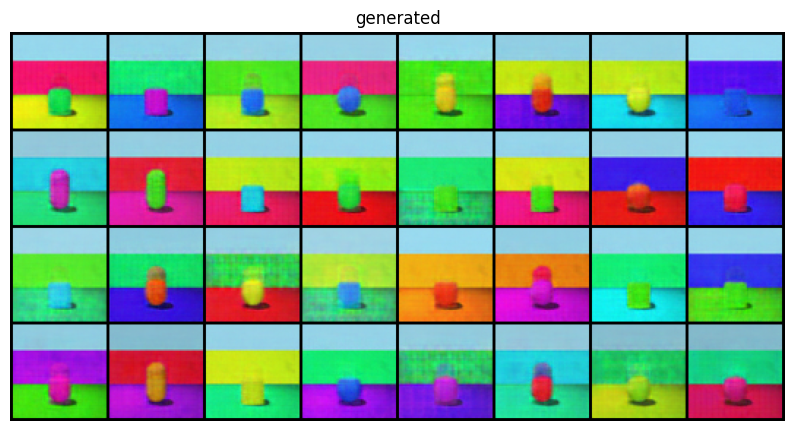

In [67]:
generated_samples = dis_s_vae_model.generate_samples(n_samples=32, device=device).cpu()
plot_tensor_grid("generated",generated_samples, n_cols=8, figsize=(10, 10), show_axis=False)

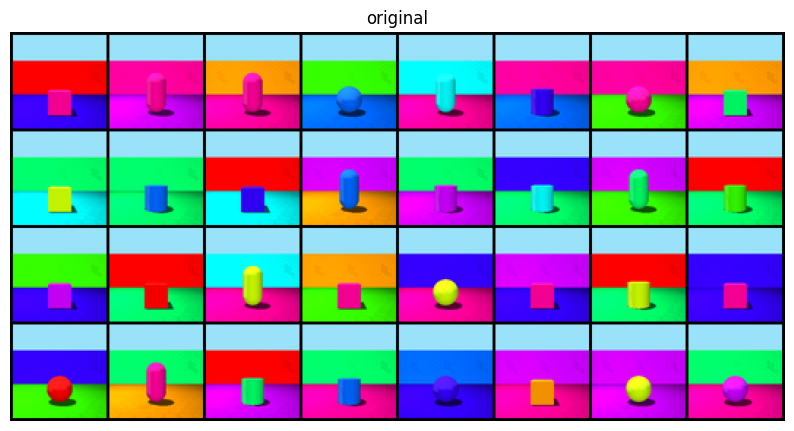

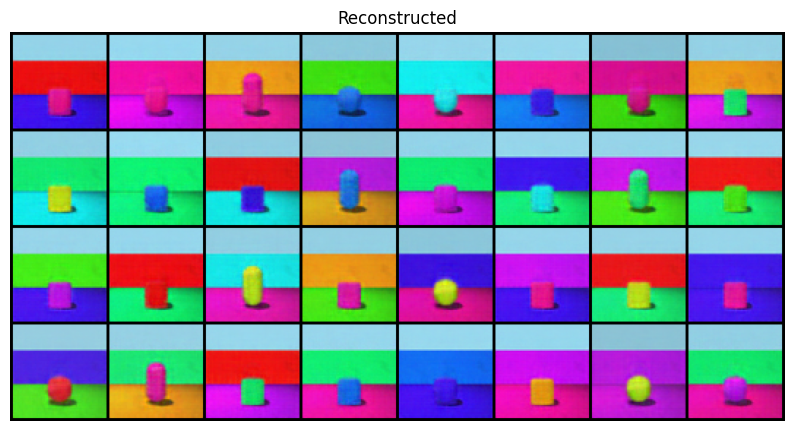

In [68]:
random_samples = random_sample_data(selected_images_3dsShapes_tensor, n_samples=32).cpu()
reconstructed_samples = dis_s_vae_model.reconstructed_samples(random_samples).cpu()


plot_tensor_grid("original", random_samples,  n_cols=8, figsize=(10, 10), show_axis=False)
plot_tensor_grid("Reconstructed", reconstructed_samples, n_cols=8, figsize=(10, 10), show_axis=False)

Sample image shape: torch.Size([3, 64, 64])
Generated samples shape: torch.Size([28, 3, 64, 64])


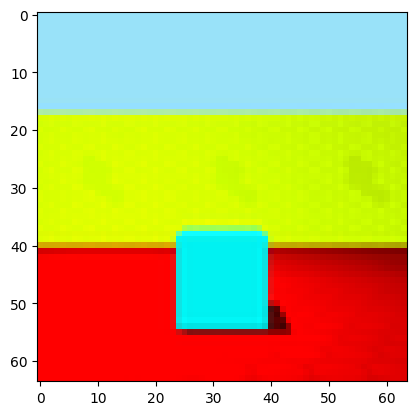

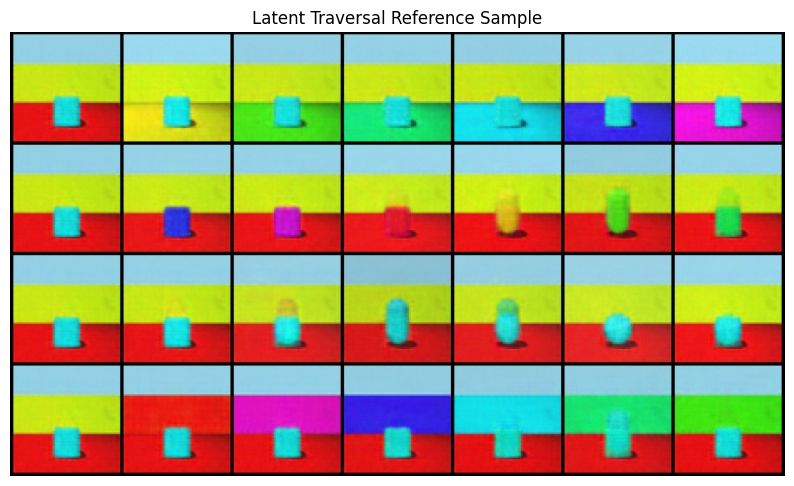

In [75]:
sample_img = shape_3d_dataset[100][0]
plt.imshow(sample_img.permute(1, 2, 0))
print(f"Sample image shape: {sample_img.shape}")

each_dim_sample_num = 7

generated_samples = dis_s_vae_model.latent_traversal_reference_sample(sample_img.unsqueeze(0), each_dim_sample_num=each_dim_sample_num, device=device)
print(f"Generated samples shape: {generated_samples.shape}")

plot_tensor_grid("Latent Traversal Reference Sample", generated_samples, n_cols=each_dim_sample_num, figsize=(10, 10), show_axis=False)

In [78]:
! tensorboard --logdir lightning_logs --bind_all

2024-10-07 16:41:32.180608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 16:41:32.180660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 16:41:32.181737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 16:41:32.187535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 16:41:32.863264: W tensorflow/compiler/tf2

# dsprites-dataset

In [94]:
# hyperparameters
z_dims = [2] * 4
lr = 1e-4

batch_size = 64
epochs = 500
encoder_input_channels_num = 1
decoder_output_channels_num = 1

recon_loss_type = "bce"
recon_loss_reduction = "batchmean"
normalize_decoder = True

kl_loss_weight = 15
# beta_scheduler = BetaLinearScheduler(beta_start=1e-3, beta_end=kl_loss_weight, n_epochs=epochs, warmup_ratio=0.8)
beta_scheduler = BetaCycleScheduler(beta_start=0, beta_end=kl_loss_weight, n_epochs=epochs, n_cycle=4, ratio=0.5)

In [95]:
dSprites_dataset = DatasetTensor(selected_dSprites_images, selected_dSprites_latents_values)
train_dataloader = DataLoader(dSprites_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=7, persistent_workers=True)

In [96]:
logger = TensorBoardLogger("lightning_logs", name="dis-s-vae-dSprites")

In [97]:
dis_s_vae_model = Dis_S_VAE(z_dims=z_dims,
                    encoder_input_channels_num=encoder_input_channels_num,
                    decoder_output_channels_num=decoder_output_channels_num,
                    lr=lr,
                    kl_loss_weight=kl_loss_weight,
                    recon_loss_type=recon_loss_type,
                    recon_loss_reduction=recon_loss_reduction,
                    normalize_decoder=normalize_decoder)

trainer = pl.Trainer(max_epochs=epochs, enable_progress_bar=True, logger=logger, callbacks=[beta_scheduler])
trainer.fit(dis_s_vae_model, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | encoder        | Encoder    | 381 K  | train
1 | decoder        | Decoder    | 380 K  | train
2 | mu_networks    | ModuleList | 136    | train
3 | kappa_networks | ModuleList | 68     | train
------------------------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.052     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


z: torch.Size([32, 8])


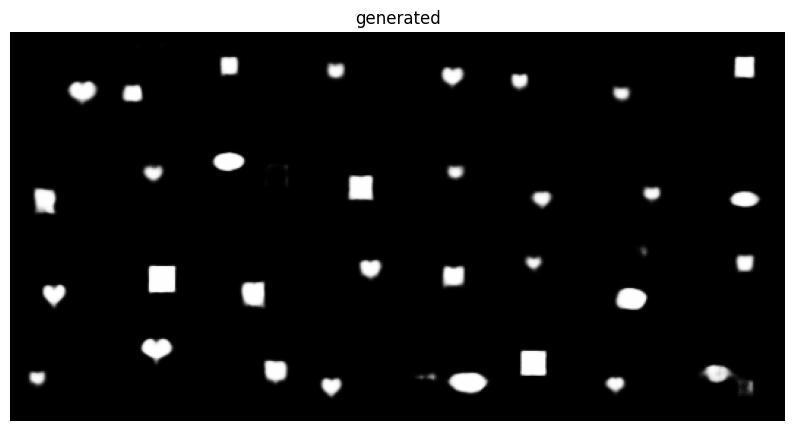

In [109]:
generated_samples = dis_s_vae_model.generate_samples(n_samples=32).cpu()
plot_tensor_grid("generated",generated_samples, n_cols=8, figsize=(10, 10), show_axis=False)

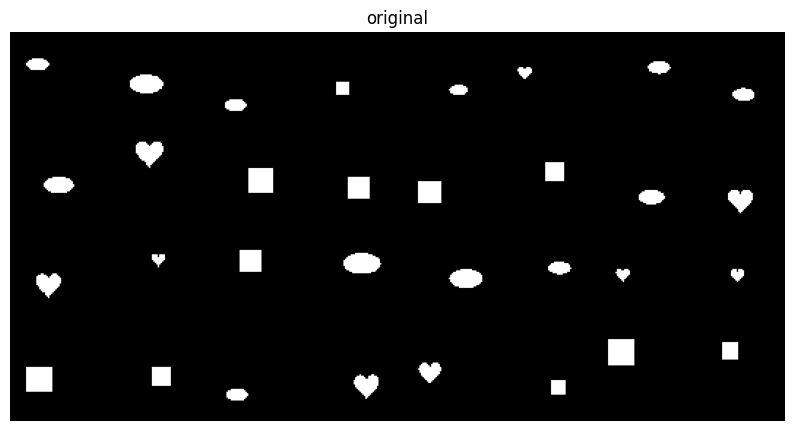

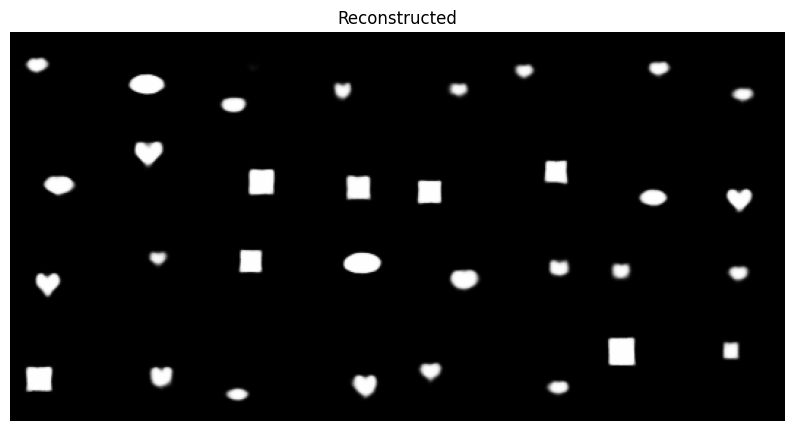

In [101]:
random_samples = random_sample_data(selected_dSprites_images, n_samples=32).cpu()
reconstructed_samples = dis_s_vae_model.reconstructed_samples(random_samples).cpu()


plot_tensor_grid("original", random_samples,  n_cols=8, figsize=(10, 10), show_axis=False)
plot_tensor_grid("Reconstructed", reconstructed_samples, n_cols=8, figsize=(10, 10), show_axis=False)

Sample image shape: torch.Size([1, 64, 64])


TypeError: Dis_S_VAE.latent_traversal_reference_sample() missing 1 required positional argument: 'device'

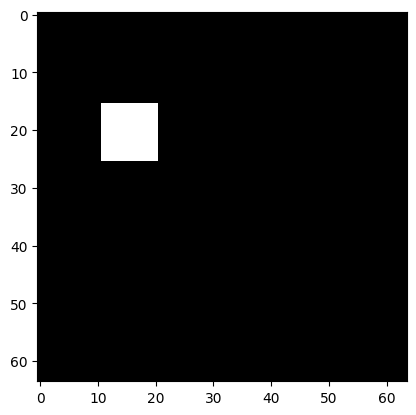

In [83]:
sample_img = dSprites_dataset[5][0]
plt.imshow(sample_img.squeeze(), cmap='gray')
print(f"Sample image shape: {sample_img.shape}")

each_dim_sample_num = 5

generated_samples = dis_s_vae_model.latent_traversal_reference_sample(sample_img.unsqueeze(0), each_dim_sample_num=each_dim_sample_num)
print(f"Generated samples shape: {generated_samples.shape}")

plot_tensor_grid("Latent Traversal Reference Sample", generated_samples, n_cols=each_dim_sample_num, figsize=(10, 10), show_axis=False)

In [ ]:
# Use the following command to run tensorboard on the remote server (comment it if you do not want to run tensorboard)
! tensorboard --logdir lightning_logs --bind_all

2024-10-07 20:16:14.385197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 20:16:14.385250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 20:16:14.386246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 20:16:14.391567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 20:16:15.130448: W tensorflow/compiler/tf2